# 0. Importando as bibliotecas 

In [1]:
# para manipulação de dados
import pandas as pd
import numpy as np

# para visualizações
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

# Referente ao preprocessamento dos dados
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder, CatBoostEncoder

# modelos de previsão
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# para ajustar hiperparâmetros do modelo
import optuna

# para avaliar o desempenho do modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# 1. Funções que utilizaremos

In [90]:
def modelo(modelo, X_train, y_train, cv=5, show_score=True, return_score=False):
    modelo.fit(X_train, y_train)
    # score do cross validation
    scores = cross_val_score(modelo, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)    
    scores = np.sqrt(-scores)
    std_score = scores.std()
    mean_score = scores.mean()
    
    if show_score:
        print("RMSE Cross Validation:")
        print(f'scores: {scores}')
        print(f'{mean_score:.2f} ± {std_score:.2f}')
    if return_score:
        return mean_score

In [91]:
def compute_metrics(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    # métrico no conjunto de avaliação
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))    
    print(f"RMSE Score: {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Mean Squared Error (MSE): {mse:.2f}")

In [105]:
def plot_ypred_ytrue(y_true, y_pred, figsize=(6,6)):
    plt.figure(figsize=figsize)
    plt.style.use('ggplot')

    plt.scatter(y_true, y_pred, c='blue', label='Data points')
    plt.xlabel('Valores Reais', fontsize=14)
    plt.ylabel('Valores Preditos', fontsize=14)
    plt.title('Reais x Preditos')

    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Diagonal')

    plt.legend()
    plt.show()

# 2. Importando e Conhecenhdo o dataset

O seguinte dicionário de dados pode ser usado para melhor entendimento dos atributos.

|Variável |Definição|
|--- |---|
|age| Idade do beneficiário principal|
|sex| Sexo do contratante de seguro feminino, masculino|
|bmi| Índice de massa corporal|
|children| Número de filhos cobertos pelo seguro de saúde / Número de dependentes|
|smoker| Se o contratante é fumante|
|region| A área residencial do beneficiário nos EUA, nordeste, sudeste, sudoeste, noroeste|
|charges| Custos médicos individuais cobrados pelo seguro de saúde|

In [6]:
insurance = pd.read_csv('datasets/insurance.csv')

In [7]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
rows, cols = insurance.shape
print(f'Nº de instâncias: {rows}')
print(f'Nº de features: {cols}')

Nº de instâncias: 1338
Nº de features: 7


In [9]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
# Verificando se há valores nulos
insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [11]:
# Verificando se há instâncias duplicadas
duplicated = insurance.duplicated()
print(f'Existe: {duplicated.sum()} instâncias duplicada')

Existe: 1 instâncias duplicada


In [12]:
# Exluindo valores duplicados
insurance.drop_duplicates(inplace=True)

In [13]:
rows_new = insurance.shape[0]

In [14]:
print(f'Nº de instâncias antes: ({rows})')
print(f'Nº de instancias depois: ({rows_new})')

Nº de instâncias antes: (1338)
Nº de instancias depois: (1337)


In [15]:
X = insurance.drop('charges', axis=1)
y = insurance['charges']

In [16]:
# Dividindo o conjunto em treino e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42)

In [17]:
df_train = X_train.merge(y_train, left_index=True, right_index=True)

In [18]:
print(f'X_train: {X_train.shape} \ny_train: {y_train.shape}\n')
print(f'X_test: {X_test.shape} \ny_test: {y_test.shape}')

X_train: (1002, 6) 
y_train: (1002,)

X_test: (335, 6) 
y_test: (335,)


# 3. EDA ( Análise Exploratória de Dados)

In [21]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

## 2.1 Análise Univariada

### 2.1.1 Features numéricas

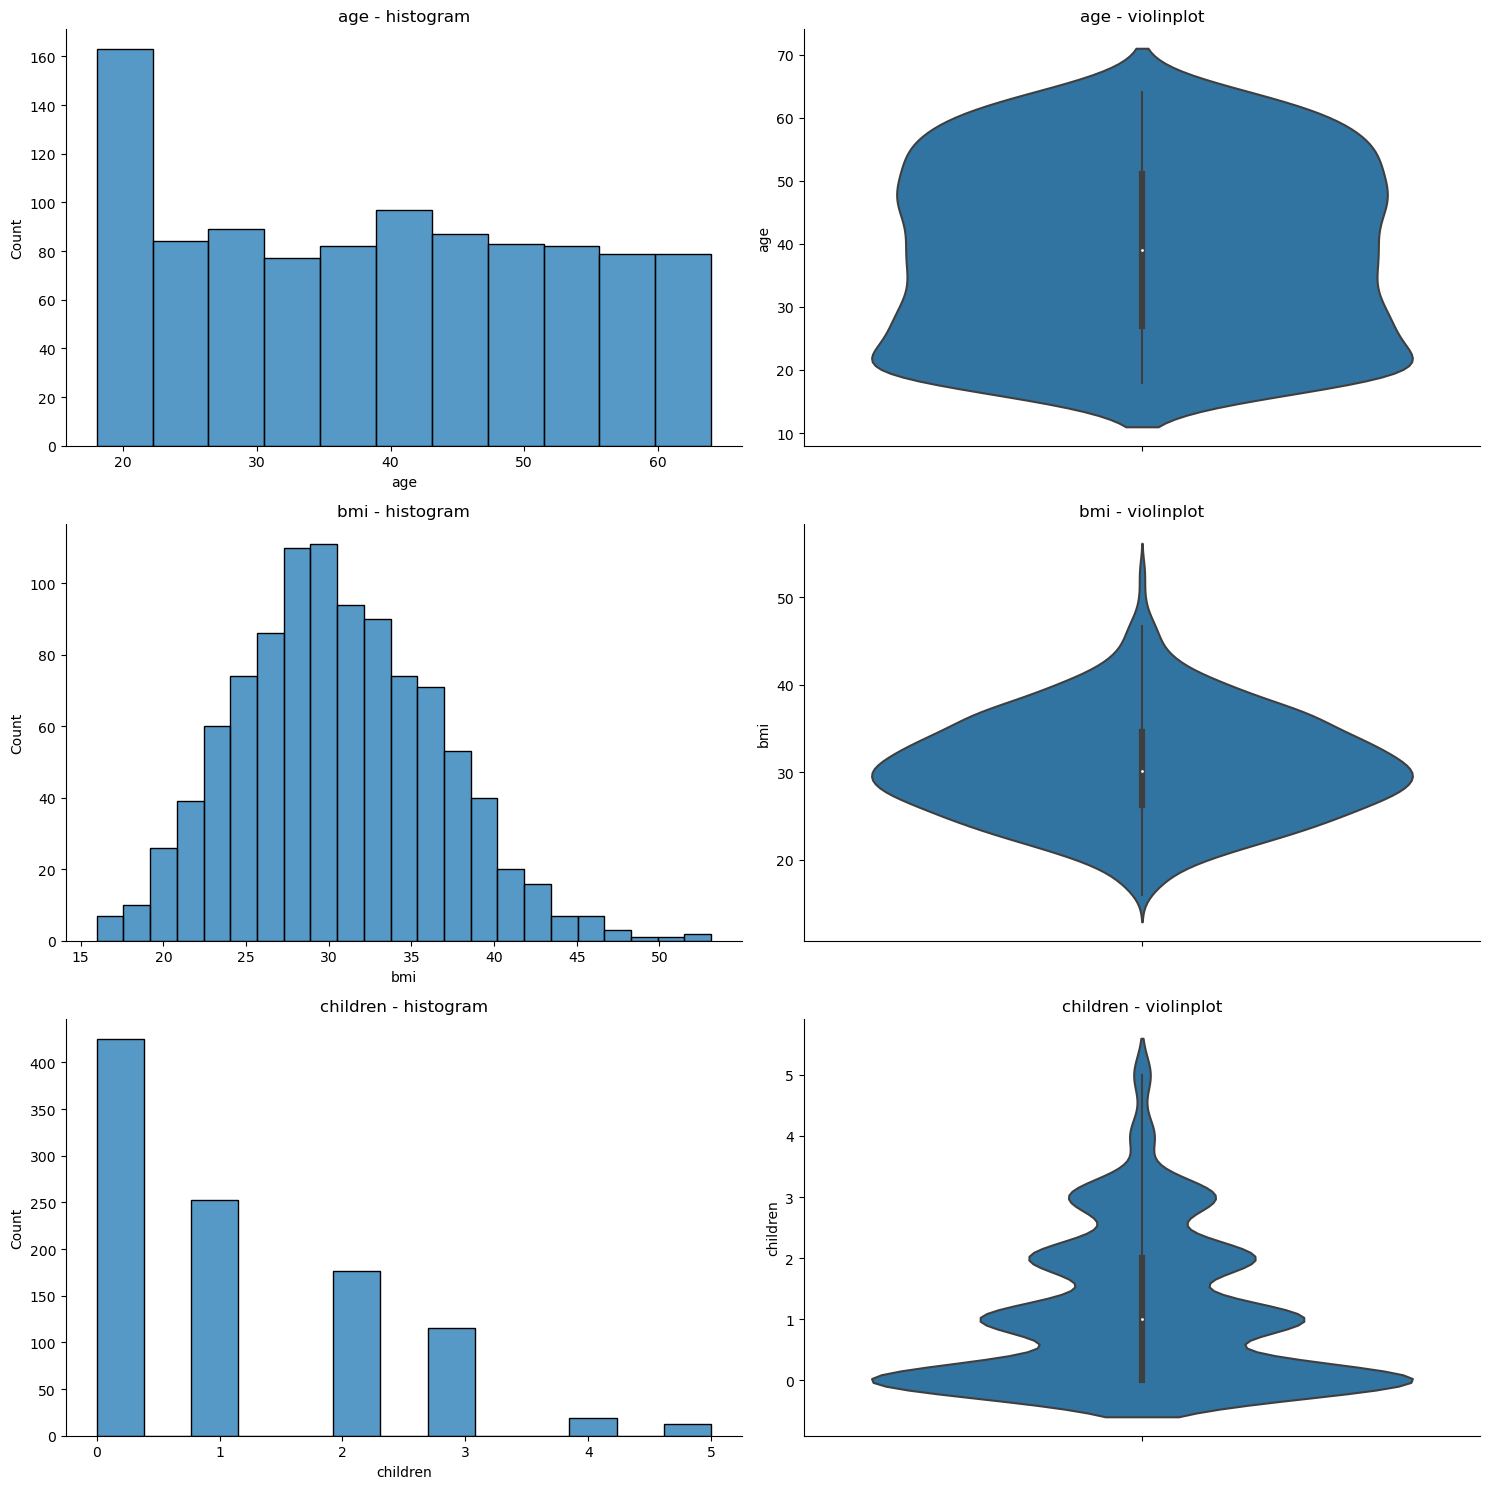

In [23]:
fig, axs = plt.subplots(len(numerical_features), 2, figsize=(15, 5 * len(numerical_features)))
axs = axs.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(data=X_train, x=feature, ax=axs[i * 2])
    axs[i * 2].set_title(f'{feature} - histogram')

    sns.violinplot(data=X_train, y=feature, ax=axs[i * 2 + 1])
    axs[i * 2 + 1].set_title(f'{feature} - violinplot')

plt.tight_layout()
sns.despine()

Observações:

------------
* **1)** A variável **age** possui uma distribuição, aproximadamente, uniforme, com uma leve concentração em clientes mais jovens.
* **2)** Metade dos clientes, tem índice de massa corporal(**bmi**) abaixo da média. Veja que essa variável possui uma leve simétria positiva (cauda a direita).
* **3)** A maior parte dos clientes, possui entre 0(não possuem) a 2 filhos cobertos pelo seguro de saúde.

### 2.1.2 Features categóricas

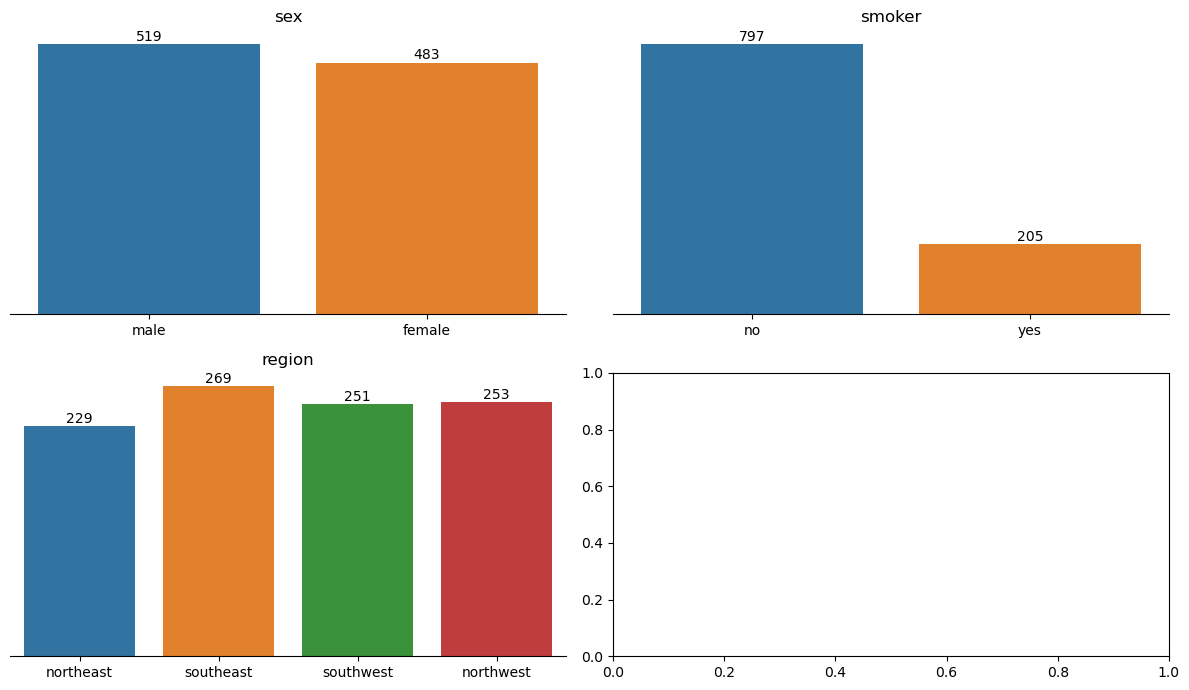

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
axs = axs.flatten()

for i, feature in enumerate(categorical_features):
    ax = axs[i]
    sns.countplot(data=X_train, x=feature, ax=ax)
    ax.set_title(f'{feature}')
    
    # Remove o nome dos eixos
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Remove os rótulos do eixo y
    ax.yaxis.set_visible(False)   
    
    # Remove o eixo y
    sns.despine(left=True, ax=ax) 
    
    # Adiciona rótulos em cima de cada barra
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.2,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [25]:
# Proporção de clientes por região
X_train['region'].value_counts(1)

southeast    0.268463
northwest    0.252495
southwest    0.250499
northeast    0.228543
Name: region, dtype: float64

In [26]:
# Proporção média de clientes por região
X_train['region'].value_counts(1).mean()

0.25

Observações:
---
---
* **1)**: A proporção entre, homens e mulheres é, aproximadamente, igual.
* **2)**: A maior parte dos contratantes não fuman.
* **3)**: A quantidade de clientes de cada região é aproximadamente igual, com a região northeast tendo cerca de 2,8% menos clientes comparado às outras regiões

## 2.2  Análise Bivariada

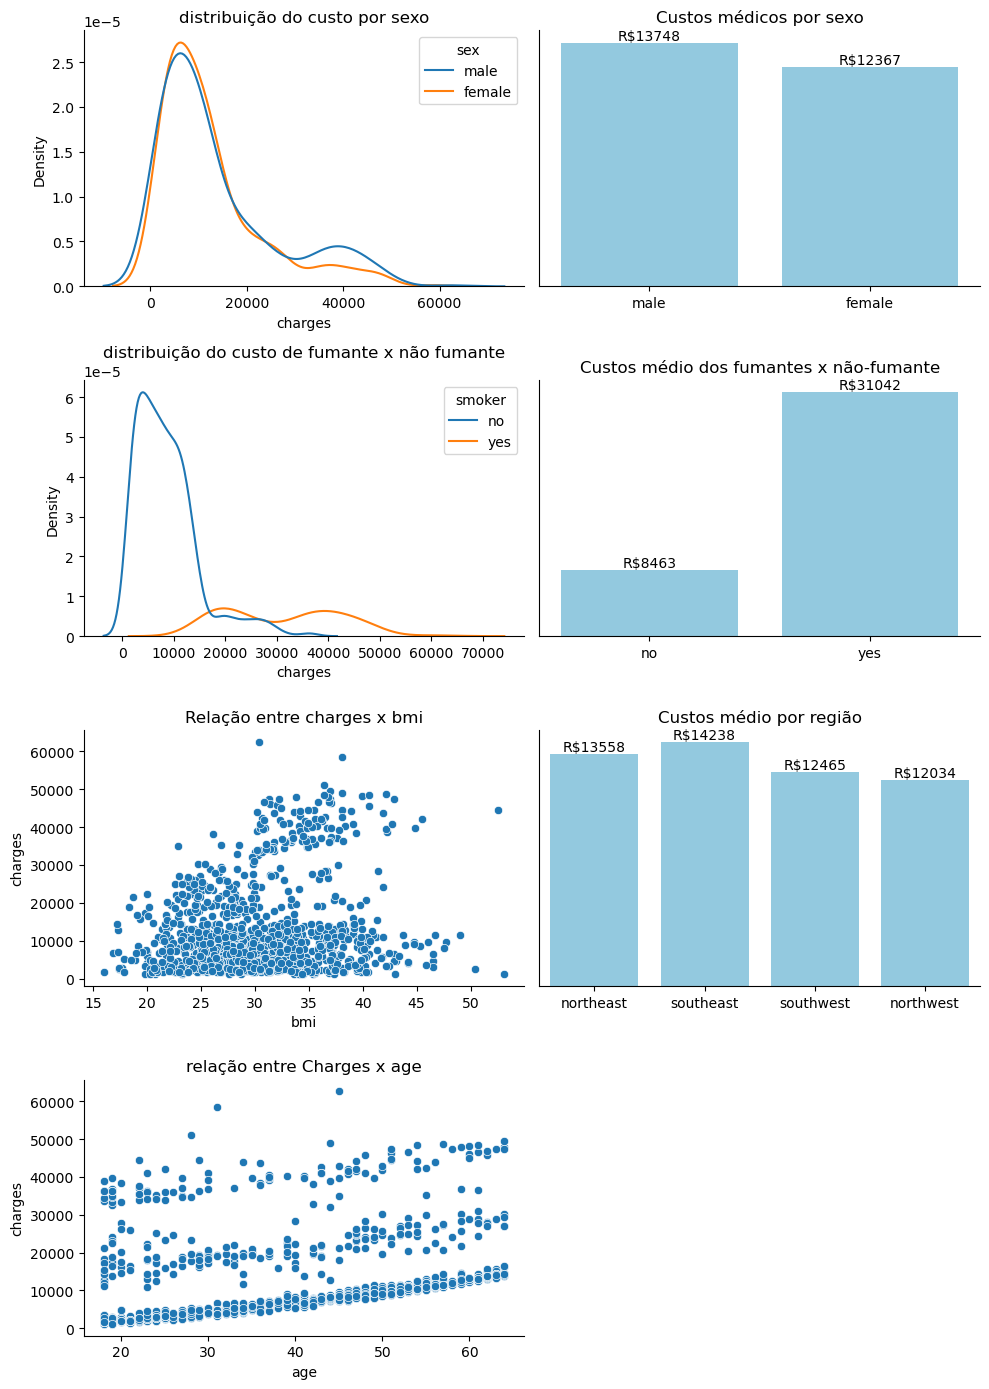

In [28]:
plt.figure(figsize=(10,14))
axs = [plt.subplot(421), plt.subplot(422), plt.subplot(423), 
       plt.subplot(424), plt.subplot(425), plt.subplot(426), 
       plt.subplot(427)]

# Plot linhas 1
sns.kdeplot(data=df_train, x='charges', hue='sex', ax=axs[0])
axs[0].set_title('distribuição do custo por sexo')

sns.barplot(df_train, x="sex", y="charges", estimator="mean", color='skyblue', errorbar=None, ax=axs[1])
axs[1].set_title('Custos médicos por sexo')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].yaxis.set_visible(False)   
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2., height + 0.2,
            f'R${height:.0f}', ha='center', va='bottom')

# Plot linhas 2
sns.kdeplot(data=df_train, x='charges', hue='smoker', ax=axs[2])
axs[2].set_title('distribuição do custo de fumante x não fumante')

sns.barplot(df_train, x="smoker", y="charges", estimator="mean", color='skyblue', errorbar=None, ax=axs[3])
axs[3].set_xlabel('')
axs[3].set_ylabel('')
axs[3].set_title('Custos médio dos fumantes x não-fumante')
axs[3].yaxis.set_visible(False)   
for p in axs[3].patches:
    height = p.get_height()
    axs[3].text(p.get_x() + p.get_width() / 2., height + 0.2,
            f'R${height:.0f}', ha='center', va='bottom')
    
# Plot linhas 3
sns.scatterplot(data=df_train, y='charges', x='bmi', ax=axs[4])
axs[4].set_title('Relação entre charges x bmi')


sns.barplot(df_train, x="region", y="charges", estimator="mean", color='skyblue', errorbar=None, ax=axs[5])
axs[5].set_xlabel('')
axs[5].set_ylabel('')
axs[5].set_title('Custos médio por região')
axs[5].yaxis.set_visible(False)   
for p in axs[5].patches:
    height = p.get_height()
    axs[5].text(p.get_x() + p.get_width() / 2., height + 0.2,
            f'R${height:.0f}', ha='center', va='bottom')

# Plot linhas 4
sns.scatterplot(data=df_train, y='charges', x='age', ax=axs[6])
axs[6].set_title('relação entre Charges x age')

sns.despine()
plt.tight_layout()
plt.show()

In [29]:
df_train.groupby(by=['children', 'smoker'])['charges'].describe()

count          mean           std          min           25%           50%           75%          max
children smoker                                                                                                       
0        no      341.0   7702.532766   5978.443850   1121.87390   2352.968450   6185.320800  11743.299000  28923.13692
         yes      84.0  29519.603838  10698.942597  13844.50600  19174.882100  30939.661825  36852.783520  62592.87309
1        no      209.0   8209.899508   5823.011075   1720.35370   4462.721800   7046.722200   9880.068000  35160.13457
         yes      44.0  31850.828187  12297.450040  15359.10450  19937.148913  31837.565800  41725.975750  58571.07448
2        no      133.0   9260.714026   6432.086828   2304.00220   4931.647000   7371.772000  11013.711900  36910.60803
         yes      44.0  33425.201347  11362.315730  12829.45510  21725.459488  36941.012650  43096.095025  49577.66240
3        no       85.0   9972.462809   5384.650788   3481.86800   6334.343550   8606.217400  12479.708950  30063.58055
         yes      30.0  31037.698478  10660.155078  16420.49455  22271.675713  27783.616850  40879.459888  48549.17835
4        no       17.0  13043.311119   8116.326851   4504.66240   7512.267000  11033.661700  15828.821730  36580.28216
         yes       2.0  30827.362400  13229.803262  21472.47880  26149.920600  30827.362400  35504.804200  40182.24600
5        no       12.0   8446.726004   2768.507424   4830.63000   6663.129400   8589.565050   9441.044450  14478.33015
         yes       1.0  19023.260000           NaN  19023.26000  19023.260000  19023.260000  19023.260000  19023.26000

Obsevações:
---
---
* **1)** Os custos médicos, cobrados para homens e mulheres, aparentemente, é igual;
* **2)** Os clientes que fumam(smoker='sim'), aparentemente, possui maior custo de saúde;
* **3)** A medida que o indice massa corporal sobre, é possivel encontrar clientes com custos mais elevados;
* **4)** Aparentemente, o custo médio de seguro saúde cobrado é igual para cada região;
* **5)** O custo de seguro saúde parece aumentar a medida que a idade cresce. Além disso, há um fato curioso, podemos ver três regiões bem definidas, como se tivesse outro atributo que combinado com a idade, forma três grupos.

## 2.3 Análise Multivariada

In [23]:
df_train.head()
df_train_aux = df_train.copy()

In [24]:
df_train_aux['smoker'] = df_train_aux['smoker'].map({'no':0, 'yes':1})
df_train_aux['region'] = df_train_aux['region'].map({'northeast':0, 'southeast':1, 'southwest':2, 'northwest':3})
df_train_aux['sex'] = df_train_aux['sex'].map({'male':0, 'female':1})

<Axes: >

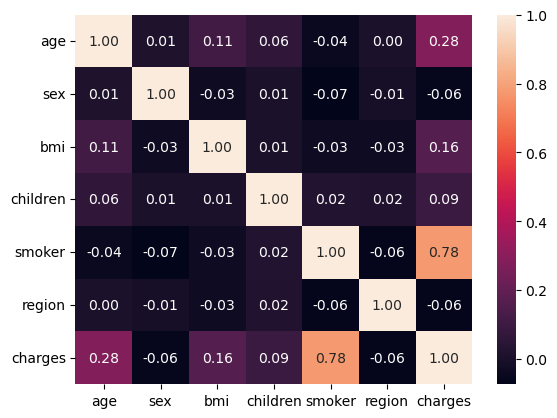

In [25]:
mat_corr = df_train_aux.corr()
sns.heatmap(mat_corr, annot=True, fmt='.2f')

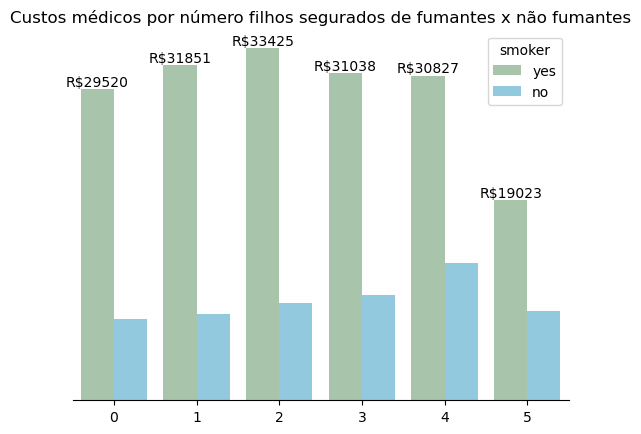

In [26]:
ax = plt.subplot(1,1,1)
sns.barplot(
    df_train, x="children", y="charges", 
    estimator="mean", hue='smoker', hue_order=['yes', 'no'], 
    palette = {'yes': '#a3c9a8', 'no': '#87ceeb'},
    errorbar=None, ax=ax)

# Remove o nome dos eixos
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Custos médicos por número filhos segurados de fumantes x não fumantes')

# Adiciona rótulos em cima de cada barra
for i, p in enumerate(ax.patches):
    # Rotulando as barras somente dos clientes fumante
    if i < 6:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.2,
                f'R${height:.0f}', ha='center', va='bottom')
    else:
        pass
    
ax.yaxis.set_visible(False)   
sns.despine(left=True, ax=ax) 

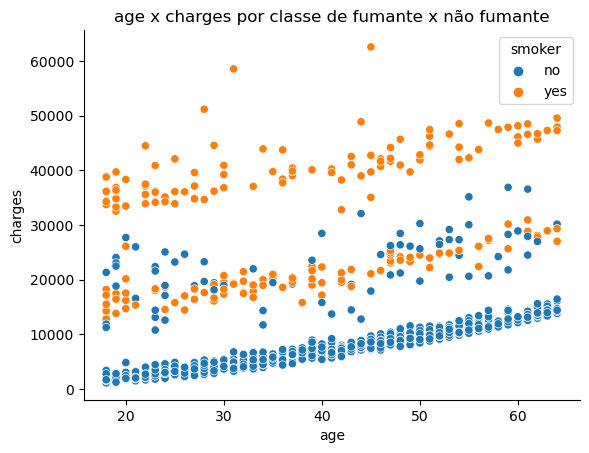

In [27]:
plt.title('age x charges por classe de fumante x não fumante')
sns.scatterplot(data=df_train, y='charges', x='age', hue='smoker')
sns.despine()

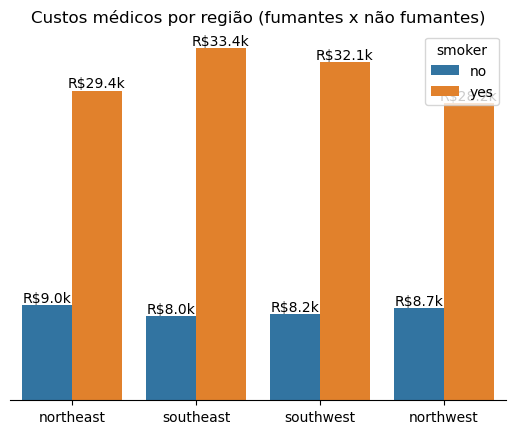

In [21]:
ax = plt.subplot(1,1,1)
sns.barplot(
    df_train, x="region", y="charges", hue='smoker',
#     estimator="mean", hue='smoker', hue_order=['yes', 'no'], 
#     palette = {'yes': '#a3c9a8', 'no': '#87ceeb'},
    errorbar=None, ax=ax)

# Remove o nome dos eixos
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Custos médicos por região (fumantes x não fumantes)')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.2,
            f'R${height/1000:.1f}k', ha='center', va='bottom')
    
ax.yaxis.set_visible(False)   
sns.despine(left=True, ax=ax) 

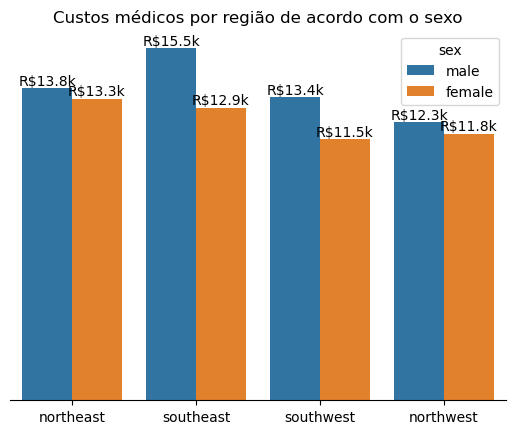

In [23]:
ax = plt.subplot(1,1,1)
sns.barplot(
    df_train, x="region", y="charges", hue='sex',
#     estimator="mean", hue='smoker', hue_order=['yes', 'no'], 
#     palette = {'yes': '#a3c9a8', 'no': '#87ceeb'},
    errorbar=None, ax=ax)

# Remove o nome dos eixos
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Custos médicos por região de acordo com o sexo')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.2,
            f'R${height/1000:.1f}k', ha='center', va='bottom')
    
ax.yaxis.set_visible(False)   
sns.despine(left=True, ax=ax) 

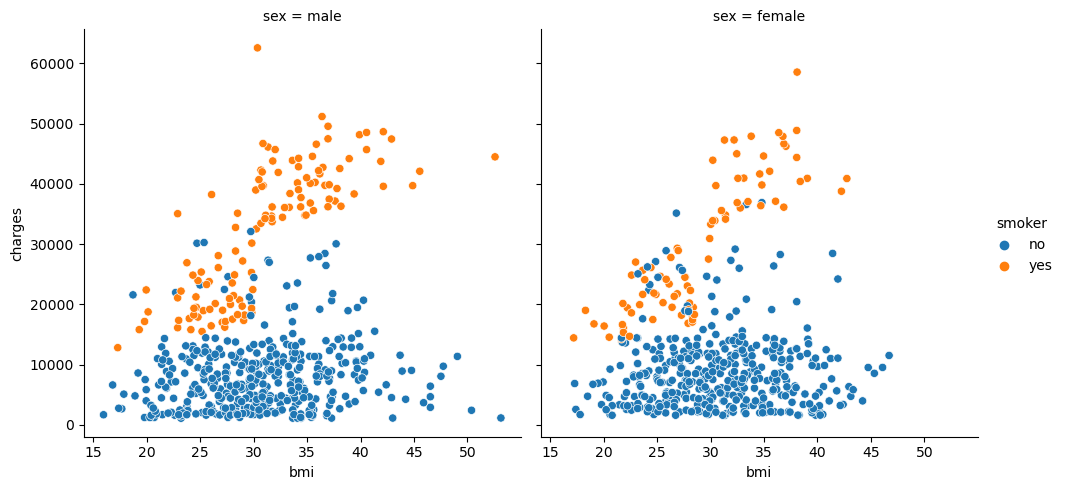

In [30]:
sns.relplot(
    data=df_train, y='charges', x='bmi', 
    hue='smoker', col="sex", kind="scatter")

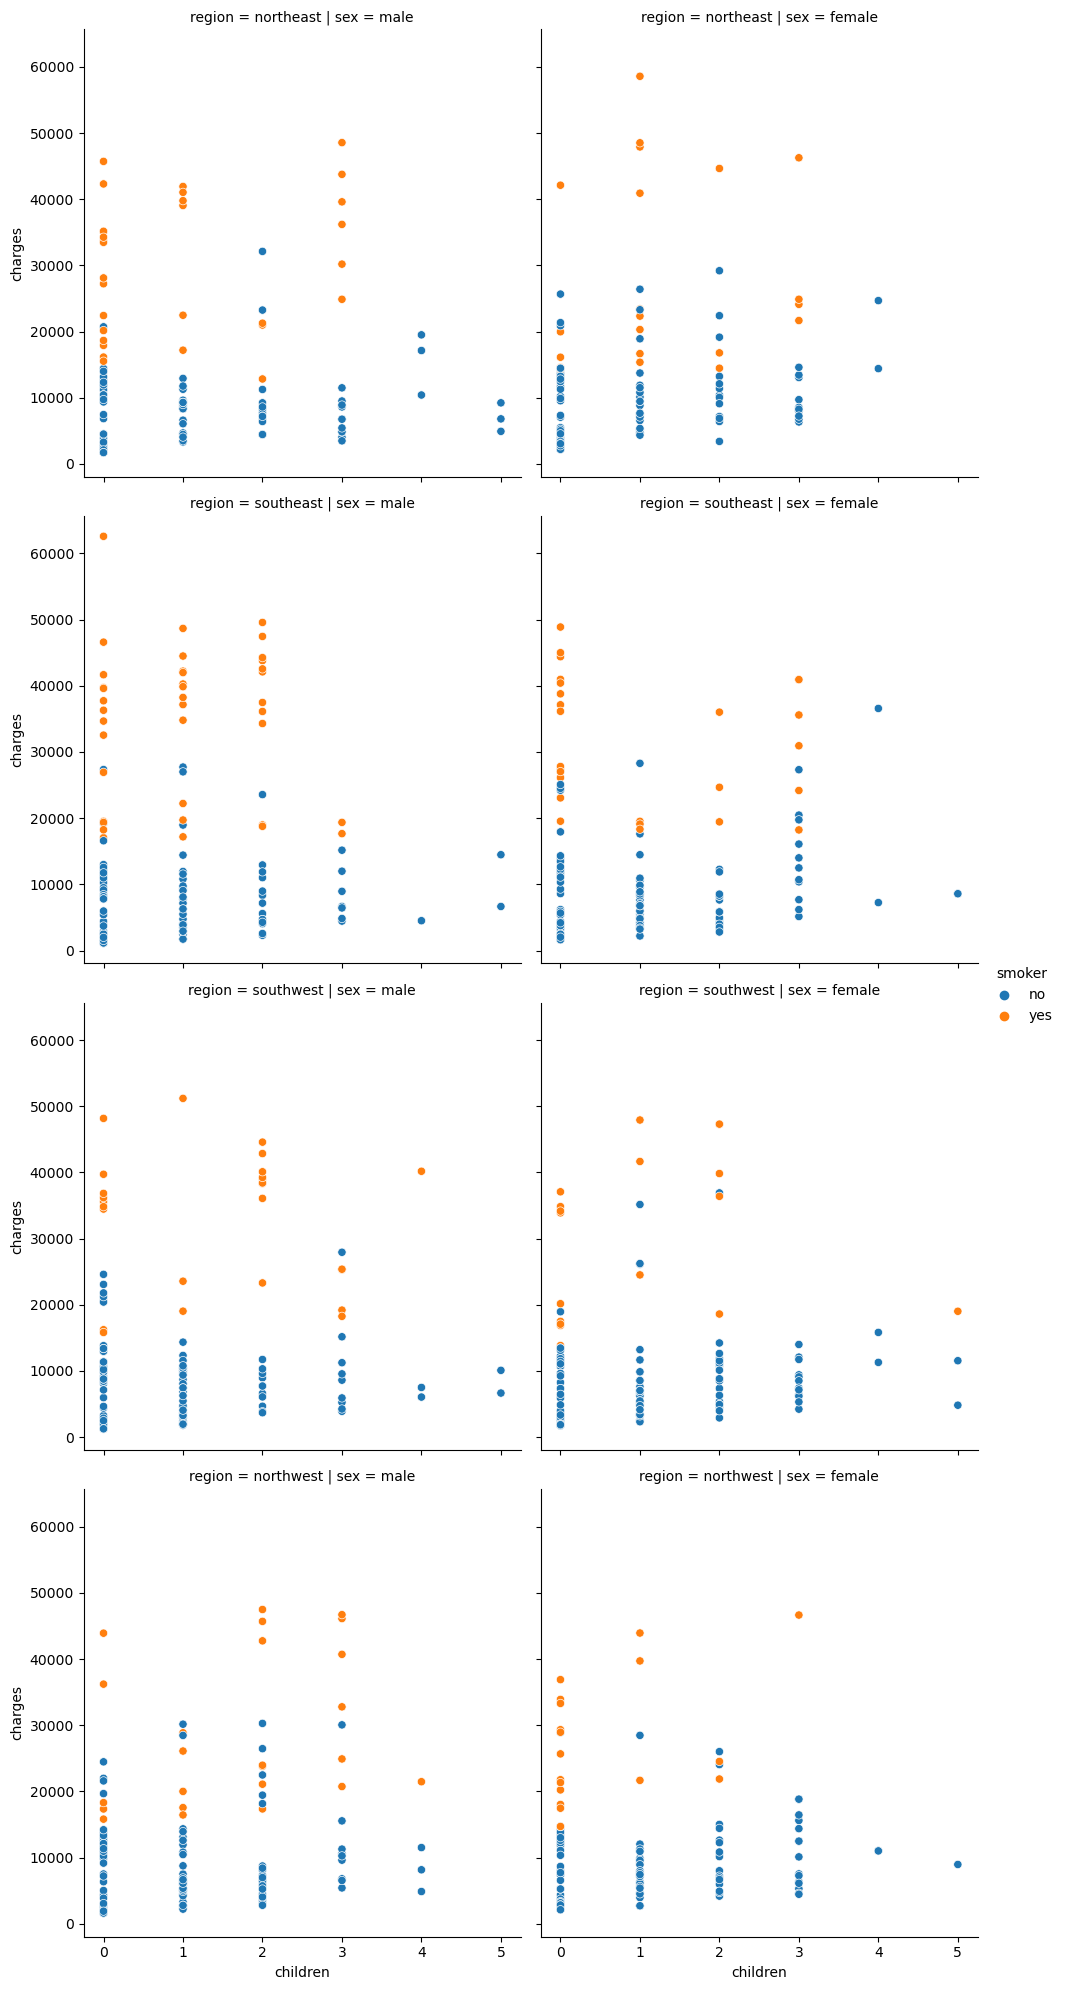

In [31]:
sns.relplot(
    data=df_train, y='charges', x='children', 
    hue='smoker', col="sex", kind="scatter", row='region')

Observação:
---
---
* **1)** Aparentemente, o custo médio do seguro de saúde é maior para os clientes fumantes. Além disso, há uma leve tendência de os clientes não fumantes apresentarem custos maiores à medida que o número de filhos cobertos aumenta, com uma exceção no caso de clientes com cinco filhos. Contudo, é importante destacar que, para esse caso, o número de clientes é menor em comparação com as outras situações. Em números, temos 12 clientes não fumantes com cinco filhos e apenas um cliente fumante com cinco filhos. Isso significa que estamos sujeitos a uma maior variabilidade nesses casos.
* **2)** À medida que a idade aumenta, os custos tendem a subir. No entanto, se o cliente for fumante, os custos podem ser ainda maiores. No gráfico, observe que, para um cliente de 20 anos, os custos podem variar de praticamente zero até cerca de 40.000, dependendo se ele fuma ou não.
* **3)** Uma das características que mais influencia o custo cobrado é se o cliente é fumante ou não. Além disso, outras características também afetam o custo, mas de forma menos intensa.

# 4. Preprocessamento

In [22]:
num_pipeline = Pipeline([
    ('imputernum', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputercat', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ]
)

In [23]:
# X_train_transformed = preprocessor.fit_transform(X_train, y_train)
# X_test_transformed = preprocessor.transform(X_test)

In [24]:
pipe_preprocessor = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())]
)

X_train_transformed = pipe_preprocessor.fit_transform(X_train, y_train)
X_test_transformed = pipe_preprocessor.transform(X_test)

# 5. Modelagem

## 5.1 Testando modelos

### Linear Regression

In [276]:
reg_linear = LinearRegression()

In [277]:
modelo(reg_linear, X_train_transformed, y_train)

RMSE Cross Validation:
scores: [6690.16691633 5795.40935589 6075.26126953 5914.73838679 6228.80300062]
6140.88 ± 311.20


In [278]:
compute_metrics(reg_linear, X_test_transformed, y_test)

RMSE Score: 5964.13
Mean Absolute Error (MAE): 4076.91
Mean Absolute Percentage Error (MAPE): 40.26%
Mean Squared Error (MSE): 35570792.14
Root Mean Squared Error (RMSE): 5964.13


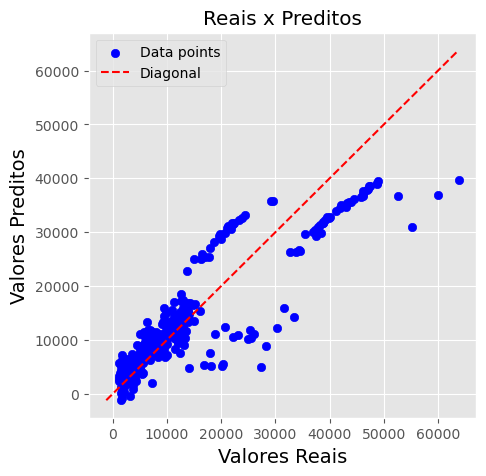

In [279]:
y_pred = reg_linear.predict(X_test_transformed)
plot_ypred_ytrue(y_test, y_pred, figsize=(5,5))

### GradientBoostingRegressor

In [273]:
reg_gbr = GradientBoostingRegressor(max_depth=3, random_state=27)

In [274]:
modelo(reg_gbr, X_train_transformed, y_train)

RMSE Cross Validation:
scores: [5224.12323557 4636.49222933 4418.98778584 4582.14101033 4778.52839559]
4728.05 ± 273.43


In [272]:
compute_metrics(reg_gbr, X_test_transformed, y_test)

RMSE Score: 4466.64
Mean Absolute Error (MAE): 2555.24
Mean Absolute Percentage Error (MAPE): 31.15%
Mean Squared Error (MSE): 19950911.12
Root Mean Squared Error (RMSE): 4466.64


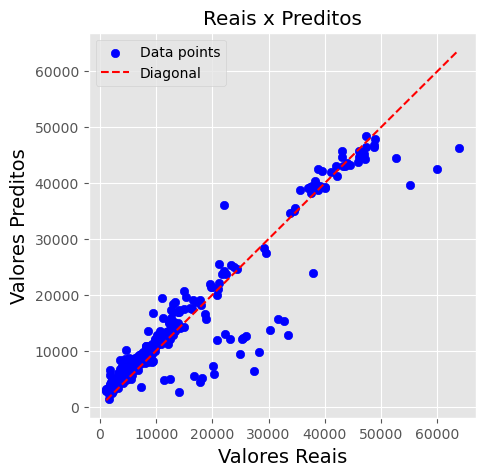

In [270]:
y_pred = reg_gbr.predict(X_test_transformed)
plot_ypred_ytrue(y_test, y_pred, figsize=(5,5))

### XGBoost

In [106]:
reg_xgb = XGBRegressor(max_depth=4, random_state=27)

In [107]:
modelo(reg_xgb, X_train_transformed, y_train, show_score=True, return_score=False)

RMSE Cross Validation:
scores: [5724.57189457 5099.30455308 5371.71696027 4922.52663883 5075.69101503]
5238.76 ± 282.75


In [108]:
compute_metrics(reg_xgb, X_test_transformed, y_test)

RMSE Score: 4973.59
Mean Absolute Error (MAE): 2888.62
Mean Absolute Percentage Error (MAPE): 38.81%
Mean Squared Error (MSE): 24736596.75


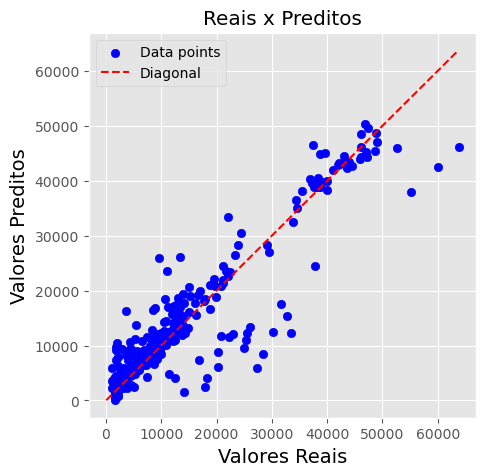

In [182]:
y_pred = reg_xgb.predict(X_test_transformed)
plot_ypred_ytrue(y_test, y_pred, figsize=(5,5))

### LightGBM

In [183]:
from lightgbm import LGBMRegressor

In [190]:
reg_lgbm = LGBMRegressor(random_state=27, verbose=0)

In [192]:
modelo(reg_lgbm, X_train_transformed, y_train)

RMSE Cross Validation: 5071.61


In [193]:
compute_metrics(reg_lgbm, X_test_transformed, y_test)

RMSE Score: 4627.68
Mean Absolute Error (MAE): 2777.71
Mean Absolute Percentage Error (MAPE): 40.35%
Mean Squared Error (MSE): 21415402.58
Root Mean Squared Error (RMSE): 4627.68


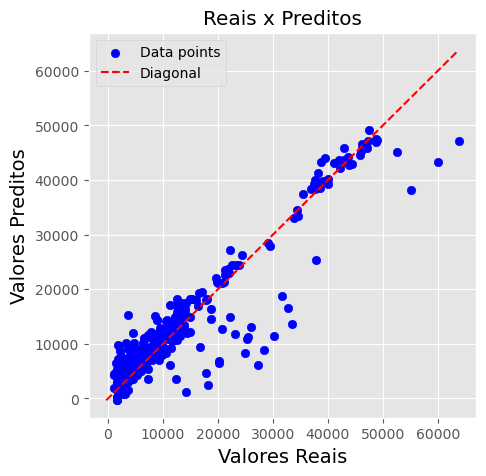

In [189]:
y_pred = reg_lgbm.predict(X_test_transformed)
plot_ypred_ytrue(y_test, y_pred, figsize=(5,5))

### Randon Florest

In [230]:
reg_rf = RandomForestRegressor(random_state=27)

In [242]:
modelo(reg_rf, X_train_transformed, y_train)

RMSE Cross Validation:
scores: [5417.46007261 4910.49338729 4900.18840393 4627.72284715 4968.6315169 ]
4964.90 ± 255.21


In [245]:
compute_metrics(reg_rf, X_test_transformed, y_test)

RMSE Score: 4782.72
Mean Absolute Error (MAE): 2644.51
Mean Absolute Percentage Error (MAPE): 39.31%
Mean Squared Error (MSE): 22874414.55
Root Mean Squared Error (RMSE): 4782.72


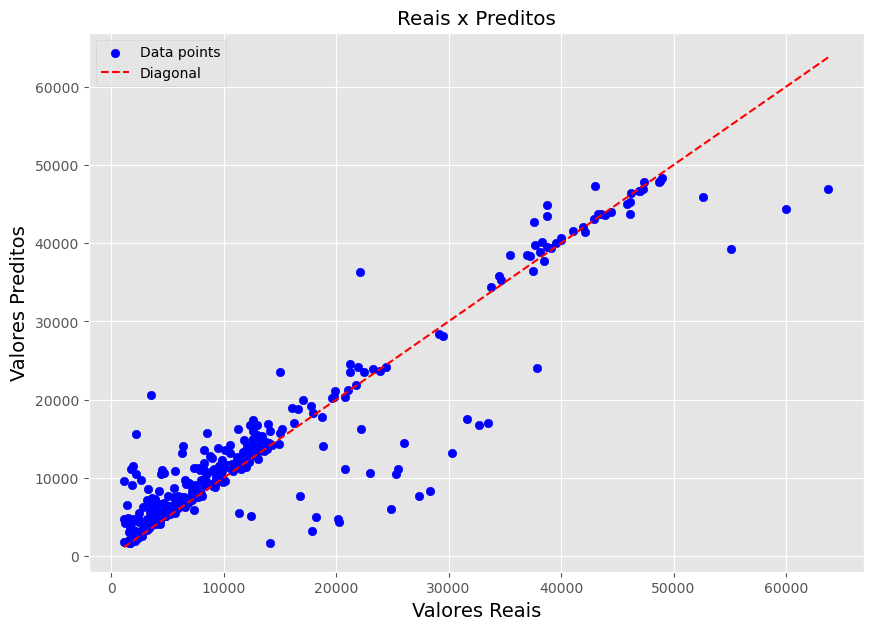

In [219]:
y_pred = reg_rf.predict(X_test_transformed)
plot_ypred_ytrue(y_test, y_pred, figsize=(10,7))

### Decision Tree

In [259]:
reg_tree = DecisionTreeRegressor(max_depth=4, random_state=27)

In [260]:
modelo(reg_tree, X_train_transformed, y_train)

RMSE Cross Validation:
scores: [5250.50423469 4647.09984738 4577.51887161 4350.9563345  4770.81531764]
4719.38 ± 298.60


In [261]:
compute_metrics(reg_tree, X_test_transformed, y_test)

RMSE Score: 4493.55
Mean Absolute Error (MAE): 2637.50
Mean Absolute Percentage Error (MAPE): 31.47%
Mean Squared Error (MSE): 20191960.73
Root Mean Squared Error (RMSE): 4493.55


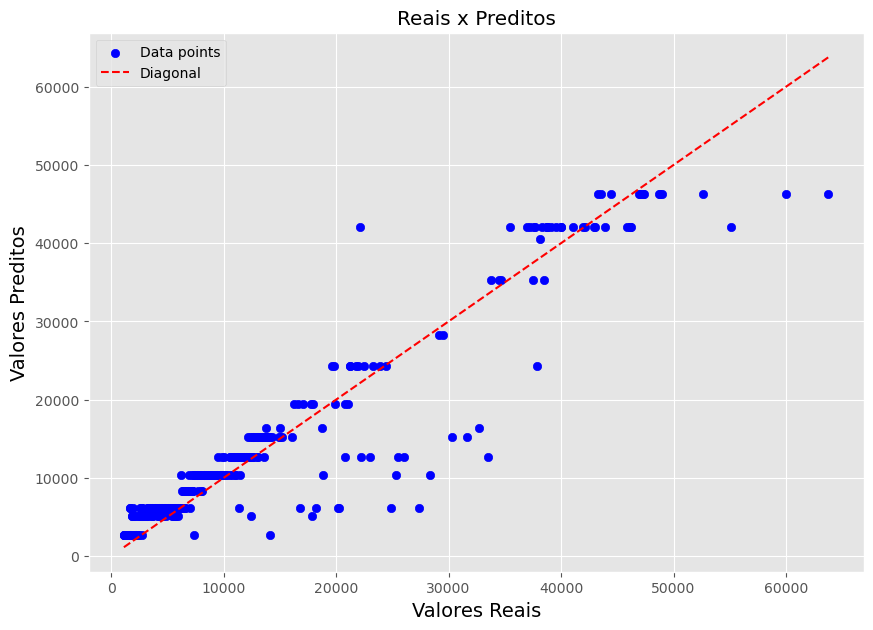

In [262]:
y_pred = reg_tree.predict(X_test_transformed)
plot_ypred_ytrue(y_test, y_pred, figsize=(10,7))

## 5.2 Feature Engineering

In [25]:
X_train_df = pd.DataFrame(X_train_transformed, columns=numerical_features + categorical_features)
X_test_df = pd.DataFrame(X_test_transformed, columns=numerical_features + categorical_features)

#### 5.2.1 Add polynomial features

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [27]:
pol = PolynomialFeatures(degree = 2)

In [28]:
X_train_poly = pol.fit_transform(X_train_df)
X_test_poly = pol.transform(X_test_df)

In [29]:
# features adicionadas
pol.get_feature_names_out()

array(['1', 'age', 'bmi', 'children', 'sex', 'smoker', 'region', 'age^2',
       'age bmi', 'age children', 'age sex', 'age smoker', 'age region',
       'bmi^2', 'bmi children', 'bmi sex', 'bmi smoker', 'bmi region',
       'children^2', 'children sex', 'children smoker', 'children region',
       'sex^2', 'sex smoker', 'sex region', 'smoker^2', 'smoker region',
       'region^2'], dtype=object)

In [30]:
X_train_poly_df = pd.DataFrame(X_train_poly, columns=pol.get_feature_names_out())
X_test_poly_df = pd.DataFrame(X_test_poly, columns=pol.get_feature_names_out())

#### 5.2.2 Feature Selection

In [31]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

 #### Importância das features antes de adicionas polinomiais

In [32]:
fs = SelectKBest(score_func=f_regression, k='all')

In [33]:
# learn relationship from training data
fs.fit_transform(X_train_df, y_train)

# transform train input data
X_train_fs = fs.transform(X_train_df)

In [34]:
scores_antes = pd.Series(fs.scores_, index=X.columns)

<Axes: >

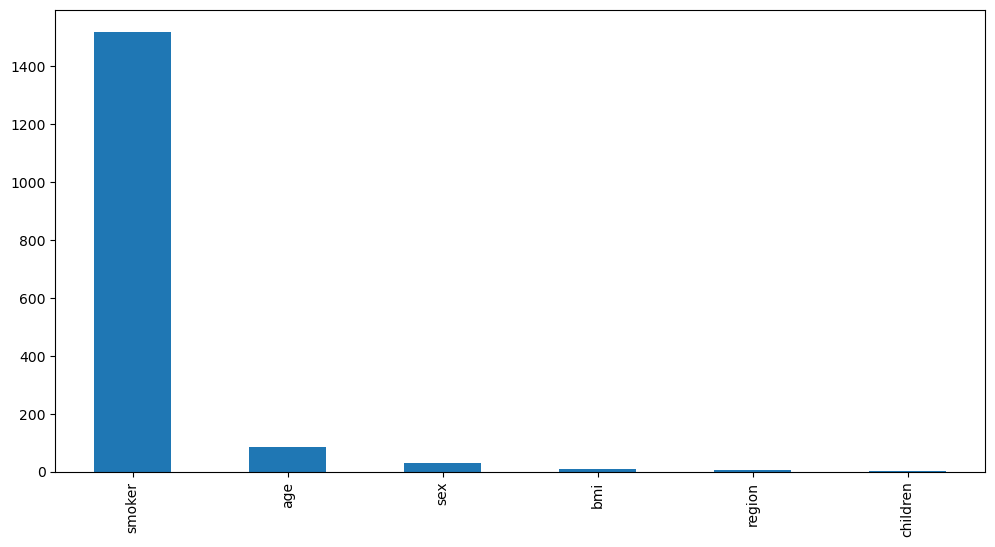

In [35]:
scores_antes.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))

 #### Importância das features após adicionar características polynomias e de interação

In [36]:
fs = SelectKBest(score_func=f_regression, k=8)

In [37]:
# transform train input data
X_train_fs = fs.fit_transform(X_train_poly_df, y_train)
X_test_fs = fs.transform(X_test_poly_df)

In [38]:
scores = pd.Series(fs.scores_, index=X_train_poly_df.columns)

<Axes: >

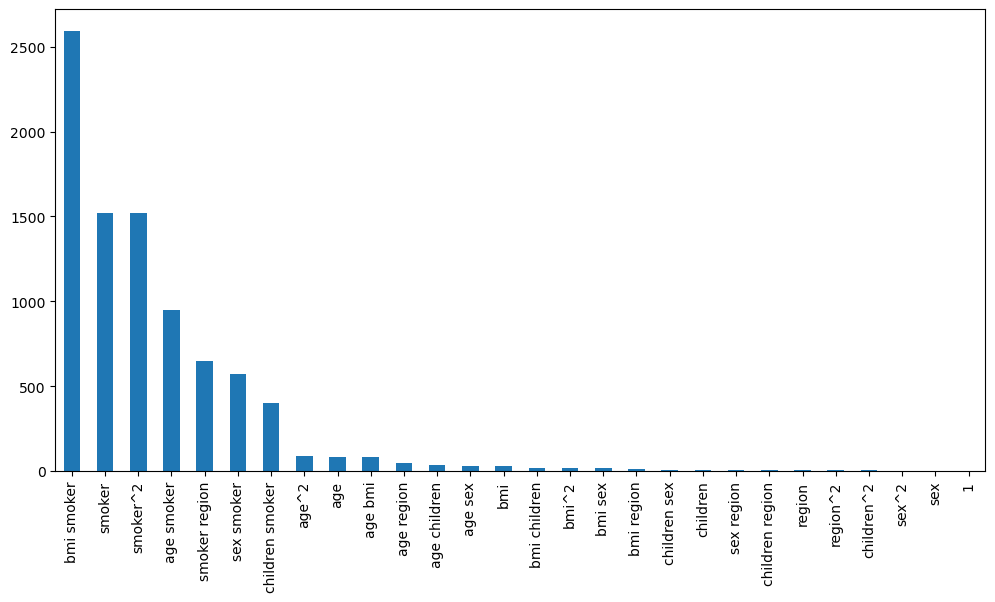

In [39]:
scores.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))

<Axes: >

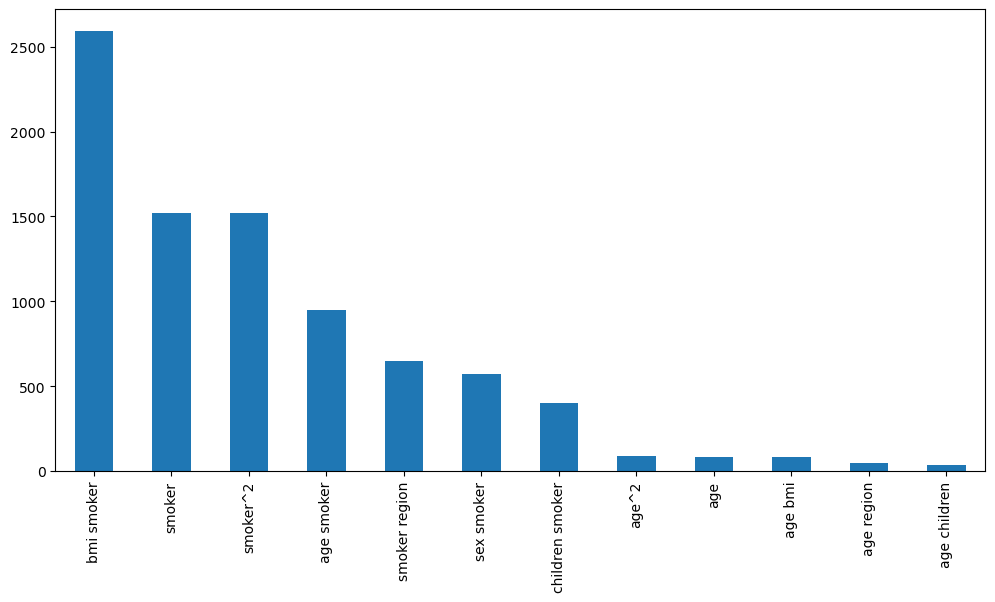

In [40]:
scores.sort_values(ascending=False)[:12].plot(kind='bar', figsize=(12, 6))

#### 5.2.3 Rodando os modelos novamente após o adicionar novas features

In [46]:
models = {    
    "Linear":LinearRegression(), 
    "gbr":GradientBoostingRegressor(max_depth=4, random_state=27), 
    "xgb":XGBRegressor(max_depth=3, random_state=27),
    "lgbm":LGBMRegressor(random_state=27, verbosity=-1),
    "rfr":RandomForestRegressor(random_state=27),
    "tree":DecisionTreeRegressor(max_depth=5, random_state=27)}

In [49]:
cont = 1
n = len(models.items())
for name, model in models.items():
    print(f'({cont}/{n}) - Model:{name}')
    modelo(model, X_train_fs, y_train)
    print()
    
    cont+=1

(1/6) - Model:Linear
RMSE Cross Validation:
scores: [5917.87550582 4804.78256244 4667.4674395  4764.56487425 4821.68339516]
4995.27 ± 464.39

(2/6) - Model:gbr
RMSE Cross Validation:
scores: [5380.35026802 4497.68662443 4309.20628859 4356.01949188 4877.75938249]
4684.20 ± 401.30

(3/6) - Model:xgb
RMSE Cross Validation:
scores: [5370.19359142 4464.98432247 4343.13332737 4404.44486161 4857.33024623]
4688.02 ± 385.52

(4/6) - Model:lgbm
RMSE Cross Validation:
scores: [5505.27171836 4563.0960619  4354.06290257 4508.63001358 4783.96035124]
4743.00 ± 405.29

(5/6) - Model:rfr
RMSE Cross Validation:
scores: [5476.99292327 4621.44699582 4411.57466117 4379.59226503 4870.21335988]
4751.96 ± 402.79

(6/6) - Model:tree
RMSE Cross Validation:
scores: [5594.12105776 4476.72982935 4410.05189399 4501.03767884 4706.62551145]
4737.71 ± 439.52



Observação:
---
--- 
Note que a maioria diminui o erro no conjunto de treino(Score Cross Validation) após adicionar novas features e selecionar as mais relevantes utilizando a função **SelectKBest** e passando a função **f_regression**.

## 5.2 Turned models

### Grandient Boosting

In [41]:
def objective_gbr(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate':trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
    }
    
    model = GradientBoostingRegressor(**param)
    score = modelo(model, X_train_fs, y_train, cv=5, show_score=False, return_score=True)
    return score

In [42]:
# Criar o estudo e otimizar
study_gbr = optuna.create_study(direction='minimize')
study_gbr.optimize(objective_gbr, n_trials=250)

[I 2024-08-03 23:14:21,139] A new study created in memory with name: no-name-06c32706-5fc1-4565-8731-45545a2256a8
[I 2024-08-03 23:14:33,756] Trial 0 finished with value: 6857.093314456019 and parameters: {'n_estimators': 424, 'learning_rate': 0.0017857676213961424, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 9, 'subsample': 0.7}. Best is trial 0 with value: 6857.093314456019.
[I 2024-08-03 23:14:36,382] Trial 1 finished with value: 4743.7600862941545 and parameters: {'n_estimators': 297, 'learning_rate': 0.020094269374660096, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6}. Best is trial 1 with value: 4743.7600862941545.
[I 2024-08-03 23:14:38,863] Trial 2 finished with value: 4747.5267243711705 and parameters: {'n_estimators': 260, 'learning_rate': 0.02167561208546045, 'max_depth': 23, 'min_samples_split': 16, 'min_samples_leaf': 5, 'subsample': 0.8}. Best is trial 1 with value: 4743.7600862941545.
[I 2024-08-03 23:14:41,501] Trial 3

[I 2024-08-03 23:17:09,306] Trial 29 finished with value: 4643.50984660124 and parameters: {'n_estimators': 451, 'learning_rate': 0.027149561422518294, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 18, 'subsample': 1.0}. Best is trial 14 with value: 4612.3688239095345.
[I 2024-08-03 23:17:16,642] Trial 30 finished with value: 4724.787237191609 and parameters: {'n_estimators': 354, 'learning_rate': 0.03284678524184666, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 9, 'subsample': 0.7}. Best is trial 14 with value: 4612.3688239095345.
[I 2024-08-03 23:17:21,736] Trial 31 finished with value: 4623.922223595788 and parameters: {'n_estimators': 404, 'learning_rate': 0.04395169852409182, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 20, 'subsample': 0.8}. Best is trial 14 with value: 4612.3688239095345.
[I 2024-08-03 23:17:26,819] Trial 32 finished with value: 4614.527869749289 and parameters: {'n_estimators': 379, 'learning_rate': 0.034207411100430

[I 2024-08-03 23:19:18,802] Trial 58 finished with value: 5182.865272989106 and parameters: {'n_estimators': 100, 'learning_rate': 0.014962958626290945, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 9, 'subsample': 0.8}. Best is trial 14 with value: 4612.3688239095345.
[I 2024-08-03 23:19:25,378] Trial 59 finished with value: 4738.635528838482 and parameters: {'n_estimators': 473, 'learning_rate': 0.046810649760117895, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 13, 'subsample': 0.8}. Best is trial 14 with value: 4612.3688239095345.
[I 2024-08-03 23:19:30,768] Trial 60 finished with value: 4717.7684261986005 and parameters: {'n_estimators': 439, 'learning_rate': 0.0364921390525232, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 8, 'subsample': 0.8}. Best is trial 14 with value: 4612.3688239095345.
[I 2024-08-03 23:19:34,016] Trial 61 finished with value: 4623.310045023836 and parameters: {'n_estimators': 394, 'learning_rate': 0.03178854753

[I 2024-08-03 23:20:37,811] Trial 87 finished with value: 4701.87596419814 and parameters: {'n_estimators': 85, 'learning_rate': 0.07297490796547428, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 14, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:20:38,890] Trial 88 finished with value: 4662.352070554995 and parameters: {'n_estimators': 84, 'learning_rate': 0.04992060443986003, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 10, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:20:40,114] Trial 89 finished with value: 4624.142685706904 and parameters: {'n_estimators': 129, 'learning_rate': 0.09408562169618502, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 12, 'subsample': 0.6}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:20:41,444] Trial 90 finished with value: 4678.436782286724 and parameters: {'n_estimators': 120, 'learning_rate': 0.07927616213434546, 'm

[I 2024-08-03 23:21:14,787] Trial 116 finished with value: 4616.98861560405 and parameters: {'n_estimators': 68, 'learning_rate': 0.08605414728197278, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 15, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:21:15,728] Trial 117 finished with value: 4662.66615289911 and parameters: {'n_estimators': 111, 'learning_rate': 0.08128107284604306, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 14, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:21:16,389] Trial 118 finished with value: 4644.963592039606 and parameters: {'n_estimators': 58, 'learning_rate': 0.09372468573494137, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 16, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:21:17,434] Trial 119 finished with value: 4641.2858874507665 and parameters: {'n_estimators': 137, 'learning_rate': 0.07136815154603518

[I 2024-08-03 23:21:43,646] Trial 145 finished with value: 4601.052839113101 and parameters: {'n_estimators': 88, 'learning_rate': 0.04587261512517871, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 14, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:21:45,771] Trial 146 finished with value: 4710.082604476488 and parameters: {'n_estimators': 105, 'learning_rate': 0.04726894201769401, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 13, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:21:46,681] Trial 147 finished with value: 4625.78052252897 and parameters: {'n_estimators': 82, 'learning_rate': 0.04423625891396592, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 13, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:21:47,812] Trial 148 finished with value: 4612.513496191378 and parameters: {'n_estimators': 91, 'learning_rate': 0.03903320449425471

[I 2024-08-03 23:22:19,182] Trial 174 finished with value: 4613.135871662673 and parameters: {'n_estimators': 107, 'learning_rate': 0.05653743761529246, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 15, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:22:20,690] Trial 175 finished with value: 4600.771931613062 and parameters: {'n_estimators': 117, 'learning_rate': 0.0731209434562441, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 16, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:22:21,782] Trial 176 finished with value: 4597.8127830722715 and parameters: {'n_estimators': 114, 'learning_rate': 0.07371196518969847, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 16, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:22:22,458] Trial 177 finished with value: 4594.910002271184 and parameters: {'n_estimators': 77, 'learning_rate': 0.073615311211930

[I 2024-08-03 23:22:48,289] Trial 203 finished with value: 4600.380175881903 and parameters: {'n_estimators': 93, 'learning_rate': 0.07012151160389704, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 17, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:22:49,277] Trial 204 finished with value: 4589.9748368475375 and parameters: {'n_estimators': 102, 'learning_rate': 0.06798798187243257, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 17, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:22:50,120] Trial 205 finished with value: 4613.1478882842985 and parameters: {'n_estimators': 104, 'learning_rate': 0.07902422306478617, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:22:51,363] Trial 206 finished with value: 4592.896512089037 and parameters: {'n_estimators': 96, 'learning_rate': 0.065859828306419

[I 2024-08-03 23:23:14,483] Trial 232 finished with value: 4599.4178067838275 and parameters: {'n_estimators': 98, 'learning_rate': 0.056900884227515, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 18, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:23:15,295] Trial 233 finished with value: 4689.952187214652 and parameters: {'n_estimators': 83, 'learning_rate': 0.06257529601453335, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 19, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:23:15,902] Trial 234 finished with value: 4598.892130750891 and parameters: {'n_estimators': 74, 'learning_rate': 0.07406535420547443, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 18, 'subsample': 0.7}. Best is trial 84 with value: 4584.598385981537.
[I 2024-08-03 23:23:16,759] Trial 235 finished with value: 4610.252150822513 and parameters: {'n_estimators': 107, 'learning_rate': 0.05270186743768944

In [46]:
best_params_gbr = study_gbr.best_params
best_params_gbr

{'n_estimators': 114,
 'learning_rate': 0.049527711235057295,
 'max_depth': 2,
 'min_samples_split': 4,
 'min_samples_leaf': 10,
 'subsample': 0.7}

In [44]:
gbr_turned = GradientBoostingRegressor(**best_params_gbr, random_state=27)

In [45]:
modelo(gbr_turned, X_train_fs, y_train, cv=5, show_score=True, return_score=False)

RMSE Cross Validation:
scores: [5307.8431292  4384.11343859 4267.21454215 4295.4330204  4680.1672475 ]
4586.95 ± 389.03


### XGBoost

In [67]:
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate':trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1, step=0.1)
    }
    
    model = XGBRegressor(**param, random_state=27)
    score = modelo(model, X_train_fs, y_train, cv=5, show_score=False, return_score=True)
    return score

In [68]:
# Criar o estudo e otimizar
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=250)

[I 2024-08-01 14:18:21,322] A new study created in memory with name: no-name-bbc76e6e-8018-4fd0-ad7c-4c441331e126
[I 2024-08-01 14:18:27,901] Trial 0 finished with value: 4976.497014577882 and parameters: {'n_estimators': 291, 'learning_rate': 0.010001815565247783, 'max_depth': 14, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 0 with value: 4976.497014577882.
[I 2024-08-01 14:18:29,566] Trial 1 finished with value: 4750.528462564491 and parameters: {'n_estimators': 196, 'learning_rate': 0.059009123060228943, 'max_depth': 15, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 1 with value: 4750.528462564491.
[I 2024-08-01 14:18:31,379] Trial 2 finished with value: 7232.767961318418 and parameters: {'n_estimators': 467, 'learning_rate': 0.002625609268523719, 'max_depth': 7, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial 1 with value: 4750.528462564491.
[I 2024-08-01 14:18:32,232] Trial 3 finished with value: 12980.197521049757 and parameters: {'n_estimators'

[I 2024-08-01 14:19:05,449] Trial 31 finished with value: 4754.865897665396 and parameters: {'n_estimators': 105, 'learning_rate': 0.03569106759246745, 'max_depth': 20, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 15 with value: 4728.241307473868.
[I 2024-08-01 14:19:06,121] Trial 32 finished with value: 4726.950682329092 and parameters: {'n_estimators': 88, 'learning_rate': 0.066545044982994, 'max_depth': 18, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 32 with value: 4726.950682329092.
[I 2024-08-01 14:19:06,631] Trial 33 finished with value: 4731.564478417384 and parameters: {'n_estimators': 79, 'learning_rate': 0.05692928460465683, 'max_depth': 14, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial 32 with value: 4726.950682329092.
[I 2024-08-01 14:19:07,153] Trial 34 finished with value: 4732.742560535992 and parameters: {'n_estimators': 78, 'learning_rate': 0.06794678012036862, 'max_depth': 14, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is t

[I 2024-08-01 14:19:22,519] Trial 63 finished with value: 4664.977333218705 and parameters: {'n_estimators': 119, 'learning_rate': 0.0831167323613101, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 44 with value: 4611.636557472244.
[I 2024-08-01 14:19:22,963] Trial 64 finished with value: 4639.687337524245 and parameters: {'n_estimators': 95, 'learning_rate': 0.08184631903350167, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 44 with value: 4611.636557472244.
[I 2024-08-01 14:19:23,685] Trial 65 finished with value: 4650.446205610152 and parameters: {'n_estimators': 212, 'learning_rate': 0.061245911026269785, 'max_depth': 2, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best is trial 44 with value: 4611.636557472244.
[I 2024-08-01 14:19:24,055] Trial 66 finished with value: 4666.758064010579 and parameters: {'n_estimators': 54, 'learning_rate': 0.0817288624127865, 'max_depth': 5, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is tri

[I 2024-08-01 14:19:40,668] Trial 95 finished with value: 4600.21864284956 and parameters: {'n_estimators': 189, 'learning_rate': 0.02680302209834017, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 87 with value: 4594.289140477946.
[I 2024-08-01 14:19:41,270] Trial 96 finished with value: 4600.400416262093 and parameters: {'n_estimators': 188, 'learning_rate': 0.026699009302082972, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 87 with value: 4594.289140477946.
[I 2024-08-01 14:19:41,990] Trial 97 finished with value: 4628.771994716655 and parameters: {'n_estimators': 189, 'learning_rate': 0.026985805167690027, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 87 with value: 4594.289140477946.
[I 2024-08-01 14:19:42,649] Trial 98 finished with value: 4615.646779931711 and parameters: {'n_estimators': 206, 'learning_rate': 0.03352072546013726, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is

[I 2024-08-01 14:20:00,123] Trial 127 finished with value: 4611.211205795032 and parameters: {'n_estimators': 176, 'learning_rate': 0.0360510744025462, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:20:00,569] Trial 128 finished with value: 4599.544042313754 and parameters: {'n_estimators': 152, 'learning_rate': 0.05154401756050597, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:20:01,404] Trial 129 finished with value: 4672.572378130765 and parameters: {'n_estimators': 221, 'learning_rate': 0.0390357384949236, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:20:01,994] Trial 130 finished with value: 4633.54745268011 and parameters: {'n_estimators': 177, 'learning_rate': 0.04502237654330167, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best

[I 2024-08-01 14:20:22,094] Trial 159 finished with value: 4643.365225576808 and parameters: {'n_estimators': 147, 'learning_rate': 0.02873433582180253, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:20:22,805] Trial 160 finished with value: 4611.864253522644 and parameters: {'n_estimators': 257, 'learning_rate': 0.03315437699479195, 'max_depth': 2, 'subsample': 0.7, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:20:23,387] Trial 161 finished with value: 4593.179803052978 and parameters: {'n_estimators': 199, 'learning_rate': 0.025786772200020857, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:20:24,620] Trial 162 finished with value: 4616.500740982455 and parameters: {'n_estimators': 465, 'learning_rate': 0.02530064082094171, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 1.0}. 

[I 2024-08-01 14:20:42,934] Trial 191 finished with value: 4595.836315768618 and parameters: {'n_estimators': 163, 'learning_rate': 0.034996560047120144, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:20:43,469] Trial 192 finished with value: 4593.884787406597 and parameters: {'n_estimators': 173, 'learning_rate': 0.03583834129961988, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:20:44,051] Trial 193 finished with value: 4596.961507585256 and parameters: {'n_estimators': 188, 'learning_rate': 0.036586541277609554, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:20:44,773] Trial 194 finished with value: 4640.905844367282 and parameters: {'n_estimators': 200, 'learning_rate': 0.05349552690173225, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0}.

[I 2024-08-01 14:21:03,581] Trial 223 finished with value: 4593.398028142095 and parameters: {'n_estimators': 220, 'learning_rate': 0.0283347181073785, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:21:04,238] Trial 224 finished with value: 4593.8168753577265 and parameters: {'n_estimators': 220, 'learning_rate': 0.027088070071896418, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:21:04,928] Trial 225 finished with value: 4593.46489709341 and parameters: {'n_estimators': 230, 'learning_rate': 0.02741529523876423, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 117 with value: 4591.111793079105.
[I 2024-08-01 14:21:05,746] Trial 226 finished with value: 4608.685092115301 and parameters: {'n_estimators': 230, 'learning_rate': 0.026257696947410033, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0}. 

In [69]:
best_params_xgb = study_xgb.best_params
best_params_xgb

{'n_estimators': 175,
 'learning_rate': 0.036120743316292385,
 'max_depth': 2,
 'subsample': 0.8,
 'colsample_bytree': 1.0}

In [70]:
xgb_turned = XGBRegressor(**best_params_xgb, random_state=27)

In [71]:
modelo(xgb_turned, X_train_fs, y_train, cv=5, show_score=True, return_score=False)

RMSE Cross Validation:
scores: [5300.51354002 4371.43386958 4286.54329343 4326.10289626 4670.9653661 ]
4591.11 ± 379.70


### LightGBM 

In [72]:
def objective_lgbm(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', -1, 25),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1)
    }
    
    model = LGBMRegressor(**param, random_state=27, verbosity=-1)
    score = modelo(model, X_train_fs, y_train, cv=5, show_score=False, return_score=True)
    return score


In [73]:
# Criar o estudo e otimizar
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=250)

[I 2024-08-01 14:21:21,890] A new study created in memory with name: no-name-b4f915b9-c0da-499c-9da1-d860ffab0d90
[I 2024-08-01 14:21:25,430] Trial 0 finished with value: 4737.265247827319 and parameters: {'n_estimators': 359, 'max_depth': 15, 'learning_rate': 0.21000000000000002, 'num_leaves': 190, 'min_child_samples': 59, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 0 with value: 4737.265247827319.
[I 2024-08-01 14:21:25,882] Trial 1 finished with value: 5097.249937371451 and parameters: {'n_estimators': 249, 'max_depth': 8, 'learning_rate': 0.12, 'num_leaves': 93, 'min_child_samples': 91, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial 0 with value: 4737.265247827319.
[I 2024-08-01 14:21:26,872] Trial 2 finished with value: 4780.2812646938955 and parameters: {'n_estimators': 217, 'max_depth': 12, 'learning_rate': 0.25, 'num_leaves': 32, 'min_child_samples': 17, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 0 with value: 4737.265247827319.
[I 2024-0

[I 2024-08-01 14:21:42,881] Trial 28 finished with value: 5081.8869475896445 and parameters: {'n_estimators': 187, 'max_depth': 18, 'learning_rate': 0.01, 'num_leaves': 19, 'min_child_samples': 33, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 25 with value: 4627.567092470445.
[I 2024-08-01 14:21:44,535] Trial 29 finished with value: 4778.616650006279 and parameters: {'n_estimators': 327, 'max_depth': 15, 'learning_rate': 0.060000000000000005, 'num_leaves': 43, 'min_child_samples': 21, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best is trial 25 with value: 4627.567092470445.
[I 2024-08-01 14:21:45,006] Trial 30 finished with value: 4620.369338133531 and parameters: {'n_estimators': 391, 'max_depth': 11, 'learning_rate': 0.05, 'num_leaves': 2, 'min_child_samples': 29, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 30 with value: 4620.369338133531.
[I 2024-08-01 14:21:45,504] Trial 31 finished with value: 4620.729974113329 and parameters: {'n_estimators': 414, 'ma

[I 2024-08-01 14:22:13,213] Trial 57 finished with value: 4699.877275684881 and parameters: {'n_estimators': 301, 'max_depth': 10, 'learning_rate': 0.09, 'num_leaves': 37, 'min_child_samples': 54, 'subsample': 0.7, 'colsample_bytree': 1.0}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:22:15,424] Trial 58 finished with value: 4761.904580665028 and parameters: {'n_estimators': 475, 'max_depth': 18, 'learning_rate': 0.05, 'num_leaves': 107, 'min_child_samples': 21, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:22:16,583] Trial 59 finished with value: 4799.491402473925 and parameters: {'n_estimators': 429, 'max_depth': 12, 'learning_rate': 0.12, 'num_leaves': 9, 'min_child_samples': 5, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:22:18,194] Trial 60 finished with value: 4720.140575510964 and parameters: {'n_estimators': 381, 'max_depth': 21, 'le

[I 2024-08-01 14:22:39,275] Trial 85 finished with value: 4708.296749543383 and parameters: {'n_estimators': 292, 'max_depth': 12, 'learning_rate': 0.05, 'num_leaves': 26, 'min_child_samples': 39, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:22:40,340] Trial 86 finished with value: 4778.821705022489 and parameters: {'n_estimators': 351, 'max_depth': 8, 'learning_rate': 0.2, 'num_leaves': 15, 'min_child_samples': 27, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:22:41,139] Trial 87 finished with value: 4721.940390761525 and parameters: {'n_estimators': 329, 'max_depth': 9, 'learning_rate': 0.12, 'num_leaves': 8, 'min_child_samples': 30, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:22:41,932] Trial 88 finished with value: 4707.673663552794 and parameters: {'n_estimators': 237, 'max_depth': 6, 'learni

[I 2024-08-01 14:23:07,420] Trial 113 finished with value: 4624.315535315363 and parameters: {'n_estimators': 270, 'max_depth': 18, 'learning_rate': 0.09, 'num_leaves': 2, 'min_child_samples': 37, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:23:08,169] Trial 114 finished with value: 4682.238474233084 and parameters: {'n_estimators': 267, 'max_depth': 16, 'learning_rate': 0.060000000000000005, 'num_leaves': 12, 'min_child_samples': 52, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:23:08,974] Trial 115 finished with value: 4734.962370515232 and parameters: {'n_estimators': 227, 'max_depth': 17, 'learning_rate': 0.09, 'num_leaves': 17, 'min_child_samples': 37, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:23:10,058] Trial 116 finished with value: 4695.435256973866 and parameters: {'n_estimators': 431, 

[I 2024-08-01 14:23:28,584] Trial 141 finished with value: 4623.86904255753 and parameters: {'n_estimators': 267, 'max_depth': 17, 'learning_rate': 0.08, 'num_leaves': 2, 'min_child_samples': 25, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:23:29,303] Trial 142 finished with value: 4682.707171284609 and parameters: {'n_estimators': 268, 'max_depth': 17, 'learning_rate': 0.06999999999999999, 'num_leaves': 7, 'min_child_samples': 25, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:23:30,271] Trial 143 finished with value: 4727.331229878564 and parameters: {'n_estimators': 275, 'max_depth': 18, 'learning_rate': 0.08, 'num_leaves': 11, 'min_child_samples': 28, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:23:31,305] Trial 144 finished with value: 4777.325248465146 and parameters: {'n_estimators': 288, 'ma

[I 2024-08-01 14:23:52,188] Trial 169 finished with value: 4622.76305076635 and parameters: {'n_estimators': 402, 'max_depth': 8, 'learning_rate': 0.060000000000000005, 'num_leaves': 2, 'min_child_samples': 23, 'subsample': 0.7, 'colsample_bytree': 1.0}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:23:53,356] Trial 170 finished with value: 4702.122950468423 and parameters: {'n_estimators': 405, 'max_depth': 7, 'learning_rate': 0.04, 'num_leaves': 10, 'min_child_samples': 28, 'subsample': 0.7, 'colsample_bytree': 1.0}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:23:53,956] Trial 171 finished with value: 4623.767064624697 and parameters: {'n_estimators': 449, 'max_depth': 8, 'learning_rate': 0.060000000000000005, 'num_leaves': 2, 'min_child_samples': 25, 'subsample': 0.7, 'colsample_bytree': 1.0}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:23:55,031] Trial 172 finished with value: 4701.462729286705 and parameters: {'n_estimat

[I 2024-08-01 14:24:21,271] Trial 198 finished with value: 4727.239924615952 and parameters: {'n_estimators': 493, 'max_depth': 6, 'learning_rate': 0.04, 'num_leaves': 18, 'min_child_samples': 17, 'subsample': 0.7, 'colsample_bytree': 1.0}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:24:22,472] Trial 199 finished with value: 4658.635534547777 and parameters: {'n_estimators': 457, 'max_depth': 5, 'learning_rate': 0.02, 'num_leaves': 7, 'min_child_samples': 22, 'subsample': 0.7, 'colsample_bytree': 1.0}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:24:23,727] Trial 200 finished with value: 4679.914133145698 and parameters: {'n_estimators': 472, 'max_depth': 4, 'learning_rate': 0.03, 'num_leaves': 13, 'min_child_samples': 23, 'subsample': 0.7, 'colsample_bytree': 1.0}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:24:24,389] Trial 201 finished with value: 4621.547062634054 and parameters: {'n_estimators': 443, 'max_depth': 7, 'le

[I 2024-08-01 14:24:50,180] Trial 227 finished with value: 4638.594562448886 and parameters: {'n_estimators': 465, 'max_depth': 2, 'learning_rate': 0.04, 'num_leaves': 7, 'min_child_samples': 28, 'subsample': 0.7, 'colsample_bytree': 1.0}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:24:50,803] Trial 228 finished with value: 4621.9048888057705 and parameters: {'n_estimators': 476, 'max_depth': 5, 'learning_rate': 0.03, 'num_leaves': 2, 'min_child_samples': 26, 'subsample': 0.7, 'colsample_bytree': 1.0}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:24:51,898] Trial 229 finished with value: 4701.953831986672 and parameters: {'n_estimators': 457, 'max_depth': 5, 'learning_rate': 0.01, 'num_leaves': 11, 'min_child_samples': 75, 'subsample': 0.7, 'colsample_bytree': 1.0}. Best is trial 50 with value: 4617.888712955368.
[I 2024-08-01 14:24:52,850] Trial 230 finished with value: 4654.416595869359 and parameters: {'n_estimators': 474, 'max_depth': 3, 'le

In [74]:
best_params_lgbm = study_lgbm.best_params
best_params_lgbm

{'n_estimators': 259,
 'max_depth': 14,
 'learning_rate': 0.06999999999999999,
 'num_leaves': 2,
 'min_child_samples': 39,
 'subsample': 0.8,
 'colsample_bytree': 0.9}

In [75]:
lbgm_turned = LGBMRegressor(**best_params_lgbm, random_state=27, verbose=-1)

In [76]:
modelo(lbgm_turned, X_train_fs, y_train, cv=5, show_score=True, return_score=False)

RMSE Cross Validation:
scores: [5333.47614581 4435.46572447 4288.5714284  4389.82180224 4642.10846386]
4617.89 ± 375.87


## 5.3 Escolha do Modelo

In [53]:
params_gbr = {
    'n_estimators': 114,
    'learning_rate': 0.049527711235057295,
    'max_depth': 2,
    'min_samples_split': 4,
    'min_samples_leaf': 10,
    'subsample': 0.7
}

gbr_turned = GradientBoostingRegressor(**params_gbr, random_state=27)

In [54]:
modelo(gbr_turned , X_train_fs, y_train, cv=5, show_score=True, return_score=False)

print()
compute_metrics(gbr_turned, X_test_fs, y_test)

RMSE Cross Validation:
scores: [5307.8431292  4384.11343859 4267.21454215 4295.4330204  4680.1672475 ]
4586.95 ± 389.03

RMSE Score: 4445.87
Mean Absolute Error (MAE): 2463.78
Mean Absolute Percentage Error (MAPE): 34.79%
Mean Squared Error (MSE): 19765741.76


In [55]:
params_xgb = {
    'n_estimators': 175,
    'learning_rate': 0.036120743316292385,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 1.0
}

xgb_turned = XGBRegressor(**params_xgb, random_state=27)

In [57]:
modelo(xgb_turned, X_train_fs, y_train, cv=5, show_score=True, return_score=False)
print()
compute_metrics(xgb_turned, X_test_fs, y_test)

RMSE Cross Validation:
scores: [5300.51354002 4371.43386958 4286.54329343 4326.10289626 4670.9653661 ]
4591.11 ± 379.70

RMSE Score: 4443.07
Mean Absolute Error (MAE): 2444.29
Mean Absolute Percentage Error (MAPE): 33.84%
Mean Squared Error (MSE): 19740863.91


In [58]:
params_lgbm = {
    'n_estimators': 259,
    'max_depth': 14,
    'learning_rate': 0.06999999999999999,
    'num_leaves': 2,
    'min_child_samples': 39,
    'subsample': 0.8,
    'colsample_bytree': 0.9
}

lbgm_turned = LGBMRegressor(**params_lgbm, random_state=27, verbose=-1)

In [59]:
modelo(lbgm_turned, X_train_fs, y_train, cv=5, show_score=True, return_score=False)
print()
compute_metrics(lbgm_turned, X_test_fs, y_test)

RMSE Cross Validation:
scores: [5333.47614581 4435.46572447 4288.5714284  4389.82180224 4642.10846386]
4617.89 ± 375.87

RMSE Score: 4375.29
Mean Absolute Error (MAE): 2430.08
Mean Absolute Percentage Error (MAPE): 34.54%
Mean Squared Error (MSE): 19143202.22


## 5.4 Modelo Final

* O modelo escolhido será o XGBRegressor turnado.
    * 1) Erro (RMSE) no conjunto de treinamento foi parecido com o erro no conjuto de teste (4591.11 e 4443.07, respectivamente);
    * 2) O erro no conjunto de teste está contido no intervalo esperado conforme foi realizado o cross-validation;
    * 3) Apresentou um desvio padrão do RMSE, levemente menor quando comparada ao do GradientBoosting;
    * 4) Além disso, o modelo estará errando, em média, cerca de 33,84% em cada previsão;

In [61]:
modelo(xgb_turned, X_train_fs, y_train, cv=5, show_score=True, return_score=False)
print()
compute_metrics(xgb_turned, X_test_fs, y_test)

RMSE Cross Validation:
scores: [5300.51354002 4371.43386958 4286.54329343 4326.10289626 4670.9653661 ]
4591.11 ± 379.70

RMSE Score: 4443.07
Mean Absolute Error (MAE): 2444.29
Mean Absolute Percentage Error (MAPE): 33.84%
Mean Squared Error (MSE): 19740863.91


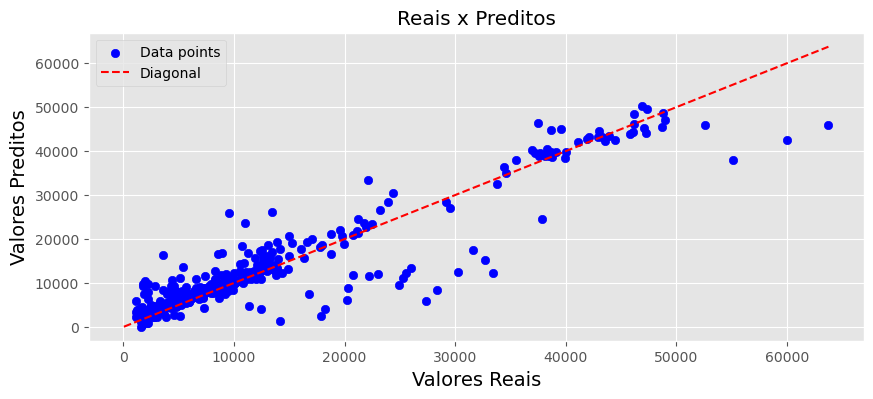

In [113]:
# Antes de feature engenierring e turnagem de hiperparâmetros
y_pred = reg_xgb.predict(X_test_transformed)
plot_ypred_ytrue(y_test, y_pred, figsize=(10,4))

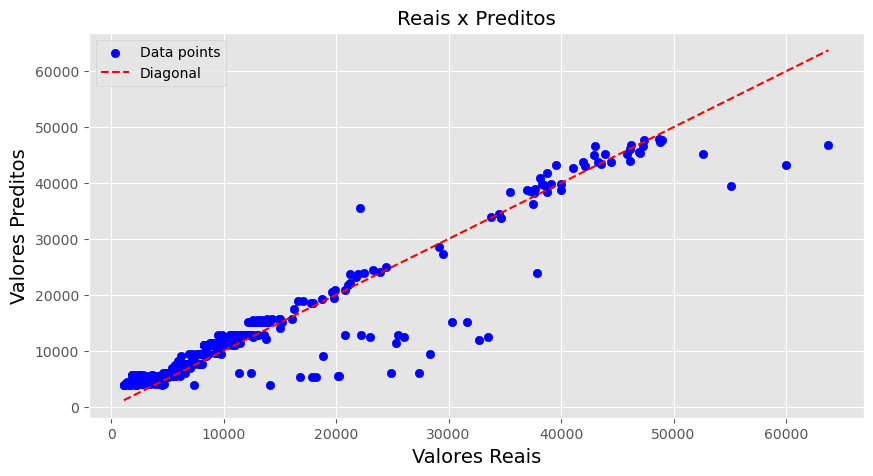

In [114]:
# Depois de feature engineering e turnagem de hiperparâmetros
y_pred = xgb_turned.predict(X_test_fs)
plot_ypred_ytrue(y_test, y_pred, figsize=(10,5))

* Aparentemente, as previsões ficaram um pouco mais precisas. No entanto, a qualidade das previões caem devido a presença de alguns outliers, ou padrões que nosso modelo não conseguiu captar. Observe que em ambas situações, existe alguns valores bem abaixo da reta. Mesmo após turnagem e feature engineering, esses valores continuaram.